In [1]:
import pandas as pd

from flask import Flask, render_template
from matplotlib import pyplot as plt
import os
import mpld3
from mpld3 import plugins
import json
import matplotlib
from matplotlib import figure
%matplotlib inline
mpld3.enable_notebook()



Max Monthly price: 11/2021 0.3249
Min Monthly price: 10/2023 0.2449
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [08/Aug/2024 15:37:53] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [08/Aug/2024 15:37:53] "GET /static/homeStyle.css HTTP/1.1" 304 -


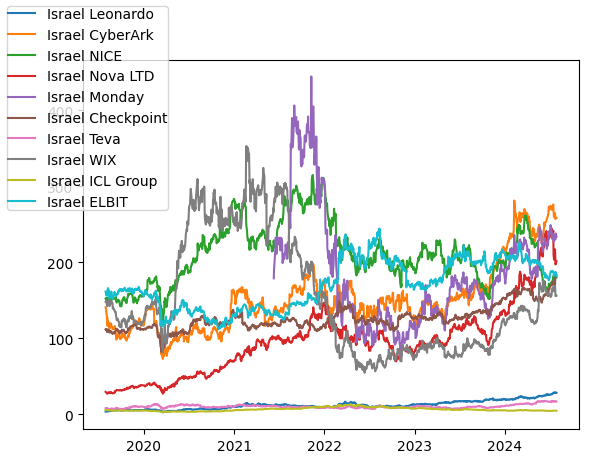

127.0.0.1 - - [08/Aug/2024 15:37:56] "GET /graphIsrael HTTP/1.1" 200 -
127.0.0.1 - - [08/Aug/2024 15:37:56] "GET /static/ILGraph.css HTTP/1.1" 304 -
127.0.0.1 - - [08/Aug/2024 15:37:56] "GET /static/Israel_sample_stock.png HTTP/1.1" 304 -
127.0.0.1 - - [08/Aug/2024 15:37:56] "GET /static/Israel_agg.png HTTP/1.1" 200 -
127.0.0.1 - - [08/Aug/2024 15:37:56] "GET /static/shekelvsdollar.png HTTP/1.1" 200 -


In [9]:
app = Flask(__name__)


def returnIsraelDFList():  # easier to do the israel and US information separately to keep track of it better even though it's redundant to do so
    israelDFList = []
    companyNamesIL = os.listdir("/Users/veredwork/Documents/Python/flaskProject/Israel_Companies")
    for name in companyNamesIL:
        israelDFList.append(
            (pd.read_excel(f"/Users/veredwork/Documents/Python/flaskProject/Israel_Companies/{name}"),name.split(".")[0]))
    for df,name in israelDFList:  # turn the dollar values into numbers and turn the date into a date-time, and add in the month and year
        df.replace(r'\$', '', regex=True, inplace=True)
        df["Close/Last"] = df["Close/Last"].astype("float")
        df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
        df["Year"] = df["Date"].dt.year
        df["Month"] = df["Date"].dt.month

    return israelDFList


def returnUSDFList():
    usDFList = []
    companyNamesUS = os.listdir("/Users/veredwork/Documents/Python/flaskProject/US_Companies/")
    for name in companyNamesUS:
        if ".xlsx" in name:
            usDFList.append(
                (pd.read_excel(f"/Users/veredwork/Documents/Python/flaskProject/US_Companies/{name}"),name.split(".")[0]))
    for df,name in usDFList:
        df.replace(r'\$', '', regex=True, inplace=True)
        df["Close/Last"] = df["Close/Last"].astype("float")
        df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
        df["Year"] = df["Date"].dt.year
        df["Month"] = df["Date"].dt.month
    return usDFList


def shekelanddollar():  # making the graph to compare the shekel to the dollar value, which will be put in the israel graph html
    shekelvsdollarDF = pd.read_excel("/Users/veredwork/Documents/ILS_to_USD_2019_2024.xlsx", skiprows=[0])
    shekelvsdollarDF = shekelvsdollarDF[["Date", "Price", "Change %"]]
    shekelvsdollarDF["Date"] = pd.to_datetime(shekelvsdollarDF["Date"])
    shekelvsdollarDF["Month"] = shekelvsdollarDF["Date"].dt.month
    shekelvsdollarDF["Year"] = shekelvsdollarDF["Date"].dt.year
    plt.plot(shekelvsdollarDF["Date"], shekelvsdollarDF["Price"])
    plt.title("Shekel value relative to USD ")
    plt.xlabel("Date")
    plt.ylabel("NIS value relative to USD ")
    plt.savefig("static/shekelvsdollar.png")
    plt.close()
    maxpivotTable = shekelvsdollarDF.pivot_table(index="Year", columns="Month", values="Price", aggfunc="max")
    minpivotTable = shekelvsdollarDF.pivot_table(index="Year", columns="Month", values="Price", aggfunc="min")
    monthMax = maxpivotTable.max(skipna=True).idxmax(skipna=True)
    yearMax = maxpivotTable.idxmax(skipna=True)[monthMax - 1]
    monthMin = minpivotTable.min(skipna=True).idxmin(skipna=True)
    yearMin = minpivotTable.idxmin(skipna=True)[monthMin - 1]
    print(f"Max Monthly price: {monthMax}/{yearMax}", maxpivotTable.dropna().values.max())
    print(f"Min Monthly price: {monthMin}/{yearMin}", minpivotTable.dropna().values.min())


def createPivotTable(
        df):  # creates 2 pivot tables, one of the maximum values of the stock market, and one of the minimum ones (for each company)
    df = df[["Year", "Month", "Date", "Close/Last"]]

    maxpivot = pd.pivot_table(df, index="Year", columns="Month", values="Close/Last", aggfunc="max")

    minpivot = pd.pivot_table(df, index="Year", columns="Month", values="Close/Last", aggfunc="min")
    return [maxpivot, minpivot]

@app.route("/")
def home():
    return render_template("home.html")
@app.route("/graphIsrael", methods=["GET", "POST"])
def graphI():
    dfList = returnIsraelDFList()
    dateL = dfList[0][0]["Date"]
    fig, ax = plt.subplots()
    count = 1
    axList = []
    for df,name in dfList:
        df.replace(r'\$', '', regex=True, inplace=True)
        axList.append(ax.plot(df["Date"], df["Close/Last"], label=name))
        count += 1

    fig.legend(loc = "upper left",borderpad=0.05)

    nameList = [df[1] for df in dfList]
    i = plugins.InteractiveLegendPlugin(axList, nameList)
    j =  plugins.Zoom()

    plugins.connect(fig,i)
    plugins.connect(fig,j)
    plt.show(fig)

    plt.close(fig)

    mergedDF = pd.concat([df[0] for df in dfList] ).groupby("Date")[["Date", "Close/Last"]]
    resultsdict = {}
    for key, df in mergedDF:
        df.reset_index(inplace=True)
        if df["Date"][0] not in resultsdict.keys():
            resultsdict[df["Date"][0]] = df["Close/Last"][0]

    valList = [resultsdict[key] for key in resultsdict.keys()]


    keyList = [key for key in resultsdict.keys()]
    plt.plot(keyList, valList)
    plt.xlabel("Date")
    plt.ylabel("Avg. Close Price")
    plt.title("aggregated average stock prices of Israel")





    plt.savefig("static/Israel_agg.png")
    plt.close()

    return render_template("graphIsrael.html")


@app.route("/graphUS", methods=["GET", "POST"])
def graphUS():
    dfList = returnUSDFList()
    fig, ax = plt.subplots()
    count = 1
    axList = []
    for df,name in dfList:
        df.replace(r'\$', '', regex=True, inplace=True)
        df["Close/Last"] = df["Close/Last"].astype("float")
        df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
        df["Year"] = df["Date"].dt.year
        df["Month"] = df["Date"].dt.month
        axList.append(ax.plot(df["Date"], df["Close/Last"], label=name))
        count += 1

    fig.legend(loc = "upper left",borderpad=0.05)
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.title("A sample of the U.S.'s Stock Prices ")
    nameList = [df[1] for df in dfList]

    i = plugins.InteractiveLegendPlugin(axList, nameList)
    j =  plugins.Zoom()

    plugins.connect(fig,i)
    plugins.connect(fig,j)
    plt.show(fig)

    fig.savefig("static/U.S._sample_stock.png")
    plt.close(fig)
    #fig, ax = plt.subplots()

    mergedDF = pd.concat([df[0] for df in dfList]).groupby("Date")[["Date", "Close/Last"]]
    resultsdict = {}
    for key, df in mergedDF:
        df["Close/Last"] = df["Close/Last"].aggregate("mean")
        df.reset_index(inplace=True)
        if df["Date"][0] not in resultsdict.keys():
            resultsdict[df["Date"][0]] = float(df["Close/Last"][0])

            #ax.scatter(df["Date"][0], df["Close/Last"][0])
    valList = [resultsdict[key] for key in resultsdict.keys()]
    keyList = [key for key in resultsdict.keys()]
    plt.plot(keyList,valList)
    plt.xlabel("Date")
    plt.ylabel("Avg. Close Price")


    plt.title("aggregated average stock prices of the U.S.")
    plt.savefig("static/U.S._agg.png")
    # fig.legend()
    # plt.close(fig)
    plt.close()

    return render_template("graphUS.html")


@app.route("/ilMinMaxData", methods=["GET", "POST"])
def uploadIDataToWebsite():
    israelDFList = returnIsraelDFList()

    iminMax = [["Max y/m", "Max Value", "Min y/m", "Min Value"]]
    for isdf,name in israelDFList:
        maxpivotTable, minpivotTable = createPivotTable(isdf)

        monthMax = maxpivotTable.max(skipna=True).idxmax(skipna=True)
        yearMax = maxpivotTable.idxmax(skipna=True)[monthMax - 1]
        monthMin = minpivotTable.min(skipna=True).idxmin(skipna=True)
        yearMin = minpivotTable.idxmin(skipna=True)[monthMin - 1]
        iminMax.append([f"{monthMax}/{yearMax}", float(maxpivotTable.fillna(-1).values.max()), f"{monthMin}/{yearMin}",
                        float(minpivotTable.fillna(1000000).values.min())])
    iMinMaxDF = pd.DataFrame(columns=iminMax[0], data=iminMax[1:len(iminMax)])
    data = iMinMaxDF.to_html()
    text_file = open("/Users/veredwork/Documents/Python/flaskProject/templates/iMinMax.html", "w")
    text_file.write(data)
    text_file.close()
    return render_template("iMinMax.html")


@app.route("/uMinMaxData", methods=["GET", "POST"])
def uploadUDataToWebsite():
    usDFList = returnUSDFList()

    uminMax = [["Max_ym", "Max_Value", "Min_ym", "Min_Value"]]
    for udf,name in usDFList:
        maxpivotTable, minpivotTable = createPivotTable(udf)

        monthMax = maxpivotTable.max(skipna=True).idxmax(skipna=True)
        yearMax = maxpivotTable.idxmax(skipna=True)[monthMax - 1]
        monthMin = minpivotTable.min(skipna=True).idxmin(skipna=True)
        yearMin = minpivotTable.idxmin(skipna=True)[monthMin - 1]
        uminMax.append([f"{monthMax}/{yearMax}", float(maxpivotTable.fillna(-1).values.max()), f"{monthMin}/{yearMin}",
                        float(minpivotTable.fillna(1000000).values.min())])
    uMinMaxDF = pd.DataFrame(columns=uminMax[0], data=uminMax[1:len(uminMax)])
    data = uMinMaxDF.to_html()

    text_file = open("/Users/veredwork/Documents/Python/flaskProject/templates/uMinMax.html", "w")
    text_file.write(data)
    text_file.close()
    return render_template("uMinMax.html")


shekelanddollar()
app.run(port=5000)

